9/12/2020

# Across-layer & Within-Network prediction with Copenhagen Network Study
Revision for ICWSM. ReFeX=RF, LINK=LogReg (unregularize), and node2vec (unregularize).

#### Note: we have some users with gender missing, that we drop

In [38]:
from __future__ import division
import os
import re
import itertools
from datetime import datetime, timedelta
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
folder_directory =os.getcwd()
os.chdir(folder_directory)
exec(open('python_libraries.py').read())
exec(open('LINK_revised.py').read())
np.seterr(divide='ignore', invalid='ignore')
from sklearn.ensemble import BaggingClassifier # needed for logforest

import imblearn
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) # scale ReFeX features

## Paper Figures Across-Layer
(train on one edge type, loop through testing on other edge types)

In [40]:
train_subset_type = 'facebook_friends' #'facebook_friends' #'calls' 'bt'
test_type = ['facebook_friends', 'calls', 'bt','sms']
refex_num_array = ['-1','-2','-3','']

undersampling = False #False #True 
RF = False 
auc_record_results = []


for refex_num in refex_num_array:
    auc_record = []
    for test_subset in test_type:
        # set-up TRAIN data
        x_train = pd.read_csv('../../code/refex-rolx-master'+ 
                              refex_num + 
                            '/Copenhagen-data/out_union_0.5_Copenhagen_df_'+ train_subset_type +'_undirected.csv-featureValues.csv',
                             header = None)
        x_train.head()
        df_train = pd.DataFrame({'keys':np.array(x_train[0])})
        y_train_y = pd.read_csv('../../data/CopenhagenNW/genders.csv')
        y_train_y.columns = ['keys','gender_y']


        ## modification: only subset to common keys where we know the gender
        ids_train = np.array(df_train['keys'])[np.in1d(np.array(df_train['keys']), np.array(y_train_y['keys']))]
        x_train = x_train.iloc[np.in1d(df_train['keys'], ids_train)]
        df_train = df_train.iloc[np.in1d(df_train['keys'], ids_train)]


        # set-up test data
        x_test = pd.read_csv('../../code/refex-rolx-master'+ 
                             refex_num +
                             '/Copenhagen-data/out_union_0.5_Copenhagen_df_'+ test_subset +'_undirected.csv-featureValues.csv',
                             header = None)
        df_test = pd.DataFrame({'keys':np.array(x_test[0])})
        y_test_y = pd.read_csv('../../data/CopenhagenNW/genders.csv')
        y_test_y.columns = ['keys','gender_y']
        y_test_y.head()


        ids_test = np.array(df_test['keys'])[np.in1d(np.array(df_test['keys']), np.array(y_test_y['keys']))]
        x_test = x_test.iloc[np.in1d(df_test['keys'], ids_test)]
        df_test = df_test.iloc[np.in1d(df_test['keys'], ids_test)]

        x_train = x_train.loc[:,1::] #drop IDs column
        scaler.fit(x_train) #transform each feature on [0,1]-scale
        x_train = scaler.transform(x_train)


        x_test = x_test.loc[:,1::] #drop IDs column
        scaler.fit(x_test) #transform each feature on [0,1]-scale
        x_test = scaler.transform(x_test)

        x_train_names = pd.read_csv('../../code/refex-rolx-master'+refex_num+'/Copenhagen-data/union_unique_featureNames.csv')
        x_test_names = pd.read_csv('../../code/refex-rolx-master'+refex_num+'/Copenhagen-data/union_unique_featureNames.csv')



        y_train = df_train.merge(y_train_y[['keys','gender_y']],
                how = 'left',
                on = 'keys')
        print(np.sum(y_train.gender_y.isna()))
        print(np.sum(y_train.gender_y.isnull()))
        y_test = df_test.merge(y_test_y[['keys','gender_y']],
            how = 'left',
            on = 'keys')
        print(np.sum(y_test.gender_y.isna()))
        print(np.sum(y_test.gender_y.isnull()))
        x_train_m = pd.DataFrame(np.matrix(x_train)[:,np.array(range(len(x_train_names.columns)))[np.in1d(np.array(x_train_names.columns), 
                                                                                         np.array(x_test_names.columns))]])
        x_test_m = pd.DataFrame(np.matrix(x_test)[:,np.array(range(len(x_test_names.columns)))[np.in1d(np.array(x_test_names.columns), 
                                                                                          np.array(x_train_names.columns))]])

        x_train_m.columns = np.array(x_train_names.columns)[np.in1d(np.array(x_train_names.columns), 
                                                        np.array(x_test_names.columns))]
        x_test_m.columns = np.array(x_test_names.columns)[np.in1d(np.array(x_test_names.columns), 
                                                        np.array(x_train_names.columns))]

        ## sort to be same
        arg_sort_idx = np.array(x_train_m.columns).argsort()
        x_train_m = x_train_m.iloc[:,arg_sort_idx]
        x_test_m = x_test_m.iloc[:,arg_sort_idx]

        num_features = np.shape(x_train_m)[1]
        print('num of features: ', np.int(np.round(np.log(num_features)))+1)




    
        C_vals = [10**x for x in range(-10,100)]
        model = linear_model.LogisticRegressionCV(
                                           Cs = C_vals,
                                           penalty='l2',
                                            solver='lbfgs',
                                           cv = 5, max_iter = 1000)

                
        # sanity-check that baseline is 0.5
        train_baseline = np.mean(y_train.gender_y==1)
        y_baseline = np.repeat(train_baseline,len(y_test.gender_y))
        print('baseline: '+str(metrics.roc_auc_score(label_binarize(y_test.gender_y,np.unique(y_test.gender_y)),
                                         y_baseline,average='weighted')))
                
                
        model.fit(x_train_m,
                      y_train.gender_y)

        y_predict_refex = model.predict(x_test_m)

        y_predict_refex = model.predict_proba(x_test_m)[:,1]
        print('auc: ',metrics.roc_auc_score(label_binarize(y_test.gender_y,np.unique(y_test.gender_y)),
                                         y_predict_refex,average='weighted'))
        auc_record.append(metrics.roc_auc_score(label_binarize(y_test.gender_y,np.unique(y_test.gender_y)),
                                         y_predict_refex,average='weighted'))
    auc_record_results.append(auc_record)

0
0
0
0
num of features:  3
baseline: 0.5
auc:  0.6335151276361901
0
0
0
0
num of features:  3
baseline: 0.5
auc:  0.5498168103448275
0
0
0
0
num of features:  3
baseline: 0.5
auc:  0.5270333497959502
0
0
0
0
num of features:  3
baseline: 0.5
auc:  0.5860382775119617
0
0
0
0
num of features:  4
baseline: 0.5
auc:  0.6382431619766502
0
0
0
0
num of features:  4
baseline: 0.5
auc:  0.5686745689655173
0
0
0
0
num of features:  4
baseline: 0.5
auc:  0.5151347768448961
0
0
0
0
num of features:  4
baseline: 0.5
auc:  0.6015693779904306
0
0
0
0
num of features:  4
baseline: 0.5
auc:  0.624401219335172
0
0
0
0
num of features:  4
baseline: 0.5
auc:  0.5845366379310345
0
0
0
0
num of features:  4
baseline: 0.5
auc:  0.5025278781419771
0
0
0
0
num of features:  4
baseline: 0.5
auc:  0.6183157894736843
0
0
0
0
num of features:  5
baseline: 0.5
auc:  0.6246708002405491
0
0
0
0
num of features:  5
baseline: 0.5
auc:  0.5881896551724137
0
0
0
0
num of features:  5
baseline: 0.5
auc:  0.5194042265602

### [ICWSM-Revision] Add in LINK for Across Layer

In [41]:
## Add in LINK results

## FB FRIENDS
edges = pd.read_csv('../../data/CopenhagenNW/processed_edgelist/df_facebook_friends_undirected.csv',
                   header = None)

df = pd.crosstab(edges[0], edges[1])
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,838,839,840,841,842,844,845,846,848,850
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [42]:
edges.columns = ['source','target','link']
edges.head()


,source,target,link
0,0,104,1
1,0,107,1
2,0,108,1
3,0,208,1
4,0,263,1


In [43]:
G = nx.from_pandas_edgelist(edges,source='source', target='target',
                           create_using = nx.Graph())


adj_LINK = nx.adjacency_matrix(G, nodelist = G.nodes()).todense()
tmp = pd.DataFrame(np.array(G.nodes())) # note ordering of adjacency matrix is produced by G.nodes()
tmp.columns = ['keys']
print(len(tmp))

y_train_y = pd.read_csv('../../data/CopenhagenNW/genders.csv')
y_train_y.columns = ['keys','gender_y']

tmp = tmp.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')
#print(len(tmp))
#np.sum(tmp['keys']!=G.nodes()) # quick check that gender is now in same order as nodes
#adj_LINK = adj_LINK[~tmp.gender_y.isna(),:]
#tmp = tmp[~tmp.gender_y.isna()]

800


## Add in calls for x-layer

In [44]:
## CALLS
edges_calls = pd.read_csv('../../data/CopenhagenNW/processed_edgelist/df_calls_undirected.csv',
                   header = None)

df_calls = pd.crosstab(edges_calls[0], edges_calls[1])
idx = df_calls.columns.union(df_calls.index)
df_calls = df_calls.reindex(index = idx, columns=idx, fill_value=0)

In [45]:
edges_calls.columns = ['source','target','link']
G = nx.from_pandas_edgelist(edges_calls,source='source', target='target')


adj_LINK_calls = nx.adjacency_matrix(G).todense()
tmp_calls = pd.DataFrame(np.array(G.nodes())) # note ordering of adjacency matrix is produced by G.nodes()
tmp_calls.columns = ['keys']
print(len(tmp_calls))
print(tmp_calls.head())
tmp_calls = tmp_calls.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')


536
   keys
0     0
1   208
2   512
3     3
4    48


## Add bluetooth for x-layer

In [46]:
edges_bt = pd.read_csv('../../data/CopenhagenNW/processed_edgelist/df_bt_undirected.csv',
                   header = None)

df_bt = pd.crosstab(edges_bt[0], edges_bt[1])
idx = df_bt.columns.union(df_bt.index)
df_bt = df_bt.reindex(index = idx, columns=idx, fill_value=0)

In [47]:
edges_bt.columns = ['source','target','link']
G = nx.from_pandas_edgelist(edges_bt,source='source', target='target')


adj_LINK_bt = nx.adjacency_matrix(G).todense()
tmp_bt = pd.DataFrame(np.array(G.nodes())) # note ordering of adjacency matrix is produced by G.nodes()
tmp_bt.columns = ['keys']
#print(len(tmp_calls))
#print(tmp_calls.head())
tmp_bt = tmp_bt.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')


## Add SMS for x-layer

In [48]:
edges_sms = pd.read_csv('../../data/CopenhagenNW/processed_edgelist/df_sms_undirected.csv',
                   header = None)

df_sms = pd.crosstab(edges_sms[0], edges_sms[1])
idx = df_sms.columns.union(df_sms.index)
df_sms = df_sms.reindex(index = idx, columns=idx, fill_value=0)

edges_sms.columns = ['source','target','link']
G = nx.from_pandas_edgelist(edges_sms,source='source', target='target')


adj_LINK_sms = nx.adjacency_matrix(G).todense()
tmp_sms = pd.DataFrame(np.array(G.nodes())) # note ordering of adjacency matrix is produced by G.nodes()
tmp_sms.columns = ['keys']

tmp_sms = tmp_sms.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')


In [49]:
total_keys = np.unique(np.concatenate((tmp_calls['keys'], tmp['keys'],
                                      tmp_bt['keys'],
                                      tmp_sms['keys'])))

#### 1) align adjacency matrix, and 2) add in columns

In [50]:
## add additional null columns -- based on columns that are not in total
add_null = total_keys[~np.in1d(total_keys,np.array(tmp['keys']))]


In [51]:
adj_LINK_total = np.concatenate((adj_LINK, np.zeros((len(tmp['keys']), len(add_null)))),
               axis = 1)

In [52]:
idx_col = np.argsort(np.concatenate((np.array(tmp['keys']), add_null)))

In [53]:
## train network
adj_LINK_total = adj_LINK_total[:,idx_col]

In [54]:
## calls
add_null_calls = total_keys[~np.in1d(total_keys, np.array(tmp_calls['keys']))]

adj_LINK_calls_total = np.concatenate((adj_LINK_calls, np.zeros((len(tmp_calls['keys']), len(add_null_calls)))),
               axis = 1)

idx_col_calls = np.argsort(np.concatenate((np.array(tmp_calls['keys']), add_null_calls)))
adj_LINK_calls_total = adj_LINK_calls_total[:,idx_col_calls]


In [55]:
## bt 
add_null_bt = total_keys[~np.in1d(total_keys, np.array(tmp_bt['keys']))]

adj_LINK_bt_total = np.concatenate((adj_LINK_bt, np.zeros((len(tmp_bt['keys']), len(add_null_bt)))),
               axis = 1)

idx_col_bt = np.argsort(np.concatenate((np.array(tmp_bt['keys']), add_null_bt)))
adj_LINK_bt_total = adj_LINK_bt_total[:,idx_col_bt]


In [56]:
np.shape(adj_LINK_sms)

(568, 568)

In [57]:
## sms 
add_null_sms = total_keys[~np.in1d(total_keys, np.array(tmp_sms['keys']))]

adj_LINK_sms_total = np.concatenate((adj_LINK_sms, np.zeros((len(tmp_sms['keys']), len(add_null_sms)))),
               axis = 1)

idx_col_sms = np.argsort(np.concatenate((np.array(tmp_sms['keys']), add_null_sms)))
adj_LINK_sms_total = adj_LINK_sms_total[:,idx_col_sms]


In [58]:
adj_LINK_total = adj_LINK_total[~tmp.gender_y.isna(),:]
tmp = tmp[~tmp.gender_y.isna()]


In [59]:
adj_LINK_calls_total = adj_LINK_calls_total[~tmp_calls.gender_y.isna(),:]
tmp_calls = tmp_calls[~tmp_calls.gender_y.isna()]


In [60]:
adj_LINK_bt_total = adj_LINK_bt_total[~tmp_bt.gender_y.isna(),:]
tmp_bt = tmp_bt[~tmp_bt.gender_y.isna()]


In [61]:
adj_LINK_sms_total = adj_LINK_sms_total[~tmp_sms.gender_y.isna(),:]
tmp_sms = tmp_sms[~tmp_sms.gender_y.isna()]


In [62]:
auc_LINK = []

In [63]:
## train on FB
C_vals = [10**x for x in range(-10,100)]
model = linear_model.LogisticRegressionCV(
                                   Cs = C_vals,
                                   penalty='l2',
                                    solver='lbfgs',
                                #class_weight='balanced',
                                   cv = 5, max_iter = 1000)

model.fit(adj_LINK_total,
              tmp.gender_y)


y_predict_refex = model.predict_proba(adj_LINK_calls_total)[:,1]
print('auc: ',metrics.roc_auc_score(label_binarize(tmp_calls.gender_y,np.unique(tmp_calls.gender_y)),
                                 y_predict_refex,average='weighted'))


auc_LINK.append(metrics.roc_auc_score(label_binarize(tmp_calls.gender_y,np.unique(tmp_calls.gender_y)),
                                 y_predict_refex,average='weighted'))
## test on calls

auc:  0.7319827586206896


In [64]:
## BT
y_predict_refex = model.predict_proba(adj_LINK_bt_total)[:,1]
print('auc: ',metrics.roc_auc_score(label_binarize(tmp_bt.gender_y,np.unique(tmp_bt.gender_y)),
                                 y_predict_refex,average='weighted'))
auc_LINK.append(metrics.roc_auc_score(label_binarize(tmp_bt.gender_y,np.unique(tmp_bt.gender_y)),
                                 y_predict_refex,average='weighted'))



auc:  0.6383314704582672


In [65]:
## SMS
y_predict_refex = model.predict_proba(adj_LINK_sms_total)[:,1]
print('auc: ',metrics.roc_auc_score(label_binarize(tmp_sms.gender_y,np.unique(tmp_sms.gender_y)),
                                 y_predict_refex,average='weighted'))
auc_LINK.append(metrics.roc_auc_score(label_binarize(tmp_sms.gender_y,np.unique(tmp_sms.gender_y)),
                                 y_predict_refex,average='weighted'))



auc:  0.7658181818181818


In [66]:
baseline = [0.5,0.5,0.5,0.5]

In [67]:
auc_record_results

[[0.6335151276361901,
  0.5498168103448275,
  0.5270333497959502,
  0.5860382775119617],
 [0.6382431619766502,
  0.5686745689655173,
  0.5151347768448961,
  0.6015693779904306],
 [0.624401219335172,
  0.5845366379310345,
  0.5025278781419771,
  0.6183157894736843],
 [0.6246708002405491,
  0.5881896551724137,
  0.5194042265602662,
  0.620822966507177]]

In [68]:
from matplotlib.backends.backend_pdf import PdfPages



In [69]:
auc_record_results[0][1:4]

[0.5498168103448275, 0.5270333497959502, 0.5860382775119617]

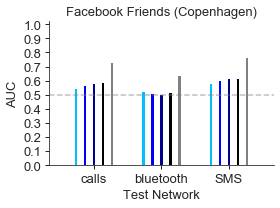

In [70]:
test_type_names = ['calls', 'bluetooth',  'SMS']



from matplotlib.backends.backend_pdf import PdfPages

alpha_empirical = 0.4

%matplotlib inline
f, (ax1) = plt.subplots(1, 1, 
                             sharey=False, sharex=False,
                            figsize=(4,3))
plt.setp(ax1, xticks=[ 0. ,  1.5,  3. ,  4.5], 
         xticklabels=test_type_names)
plt.setp(ax1.get_xticklabels(), #rotation=90, 
         size = 13)

ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0,labelsize = 13)
plt.axhline(0.5, color='gray', linestyle='--', alpha = 0.5)


w = 1.5
width = 0.08


ax1.bar(np.array(range(len(auc_record_results[0])-1))*w-0.4,auc_record_results[0][1:4], color = 'deepskyblue',# alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')

ax1.bar(np.array(range(len(auc_record_results[1])-1))*w-0.2,auc_record_results[1][1:4], color = 'blue', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')

ax1.bar(np.array(range(len(auc_record_results[2])-1))*w-0,auc_record_results[2][1:4], color = 'darkblue', #alpha = 0.5,
       width = width, edgecolor = 'white')

ax1.bar(np.array(range(len(auc_record_results[3])-1))*w+0.2,auc_record_results[3][1:4], color = 'black', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')


ax1.bar(np.array(range(len(auc_LINK)))*w+0.4,auc_LINK, color = 'gray', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')

ax1.set_ylabel('AUC', size=13)
ax1.set_xlabel('Test Network', size=13)

ax1.set_xlim(-1,np.max(np.array(range(len(auc_record)-1))*w)+1)
#ax1.set_xlim(-1,18.5)

ax1.set_ylim(0.25,1.02)

plt.yticks(np.arange(0,1.02,0.1), size = 13)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)



ax1.set_title('Facebook Friends (Copenhagen)', size = 13)
plt.tight_layout()
#if undersampling:
#    if RF:
#        pp = PdfPages('../figs-ICWSM-revision/NEWundersampleRF_' + train_subset_type + '.pdf') 
#    else:
#        pp = PdfPages('../figs-ICWSM-revision/NEWundersampleLogForest_' + train_subset_type + '.pdf' ) 
#else:
#    if RF:
#        pp = PdfPages('../figs-ICWSM-revision/NEWRF_' + train_subset_type + '.pdf') 
#    else:
#        pp = PdfPages('../figs-ICWSM-revision/NEWLogForest_' + train_subset_type + '.pdf' ) 

#pp = PdfPages('../../figs-ICWSM-revision/CopenhagenAcrossLayer.pdf' ) 
#pp.savefig(pad_inches=1 ) 
#pp.close()

In [75]:
df_results = pd.DataFrame({'test': np.array(['calls', 'bluetooth',  'SMS']),
                           'refex-1': auc_record_results[0][1:4],
                           'refex-2': auc_record_results[1][1:4],
                           'refex-3': auc_record_results[2][1:4],
                           'refex-max': auc_record_results[3][1:4],
                           'auc_LINK': auc_LINK,
                            })
df_results.to_csv('NEWCopenhagenAcrossResultsICWSMRevision.csv',sep=',', index = False)

## Paper Figures Within-Network
Compare LINK and ReFeX features as part of a Within-Network Task on the Facebook friends network of Copenhagen.


In [3]:
n_iter = 25

In [4]:
x1 = pd.read_csv('../../code/refex-rolx-master-1/'+ 
                    '/Copenhagen-data/out_union_0.5_Copenhagen_df_facebook_friends_undirected.csv-featureValues.csv',
                     header = None)
print(x1.head())
df_train = pd.DataFrame({'keys':np.array(x1[0])})
y_train_y = pd.read_csv('../../data/CopenhagenNW/genders.csv')
y_train_y.columns = ['keys','gender_y']

ids_train = np.array(df_train['keys'])[np.in1d(np.array(df_train['keys']), np.array(y_train_y['keys']))]
x1 = x1.iloc[np.in1d(df_train['keys'], ids_train)]
df_train = df_train.iloc[np.in1d(df_train['keys'], ids_train)]


x1 = x1.loc[:,1::] #drop IDs column
scaler.fit(x1) #transform each feature on [0,1]-scale
x1 = scaler.transform(x1)

y1 = df_train.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')

     0    1    2    3    4    5    6
0  338  0.0  2.0  1.0  1.0  1.0  2.0
1  339  0.0  2.0  1.0  2.0  1.0  2.0
2  332  0.0  1.0  1.0  1.0  1.0  1.0
3  333  0.0  3.0  1.0  2.0  1.0  3.0
4  330  0.0  4.0  1.0  4.0  1.0  3.0


In [5]:
x2 = pd.read_csv('../../code/refex-rolx-master-2/'+ 
                    '/Copenhagen-data/out_union_0.5_Copenhagen_df_facebook_friends_undirected.csv-featureValues.csv',
                     header = None)
df_train = pd.DataFrame({'keys':np.array(x2[0])})
y_train_y = pd.read_csv('../../data/CopenhagenNW/genders.csv')
y_train_y.columns = ['keys','gender_y']

ids_train = np.array(df_train['keys'])[np.in1d(np.array(df_train['keys']), np.array(y_train_y['keys']))]
x2 = x2.iloc[np.in1d(df_train['keys'], ids_train)]
df_train = df_train.iloc[np.in1d(df_train['keys'], ids_train)]


x2 = x2.loc[:,1::] #drop IDs column
scaler.fit(x2) #transform each feature on [0,1]-scale
x2 = scaler.transform(x2)

y2 = df_train.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')

In [6]:
x3 = pd.read_csv('../../code/refex-rolx-master-3/'+ 
                    '/Copenhagen-data/out_union_0.5_Copenhagen_df_facebook_friends_undirected.csv-featureValues.csv',
                     header = None)
df_train = pd.DataFrame({'keys':np.array(x3[0])})
y_train_y = pd.read_csv('../../data/CopenhagenNW/genders.csv')
y_train_y.columns = ['keys','gender_y']

ids_train = np.array(df_train['keys'])[np.in1d(np.array(df_train['keys']), np.array(y_train_y['keys']))]
x3 = x3.iloc[np.in1d(df_train['keys'], ids_train)]
df_train = df_train.iloc[np.in1d(df_train['keys'], ids_train)]


x3 = x3.loc[:,1::] #drop IDs column
scaler.fit(x3) #transform each feature on [0,1]-scale
x3 = scaler.transform(x3)

y3 = df_train.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')

In [7]:
xall = pd.read_csv('../../code/refex-rolx-master/'+ 
                    '/Copenhagen-data/out_union_0.5_Copenhagen_df_facebook_friends_undirected.csv-featureValues.csv',
                     header = None)
df_train = pd.DataFrame({'keys':np.array(xall[0])})
y_train_y = pd.read_csv('../../data/CopenhagenNW/genders.csv')
y_train_y.columns = ['keys','gender_y']

ids_train = np.array(df_train['keys'])[np.in1d(np.array(df_train['keys']), np.array(y_train_y['keys']))]
xall = xall.iloc[np.in1d(df_train['keys'], ids_train)]
df_train = df_train.iloc[np.in1d(df_train['keys'], ids_train)]


xall = xall.loc[:,1::] #drop IDs column
scaler.fit(xall) #transform each feature on [0,1]-scale
xall = scaler.transform(xall)

yall = df_train.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')

In [8]:
from sklearn.linear_model import LogisticRegressionCV

## additional regularized-LogReg check
C_vals = [10**x for x in range(-10,100)]
model1 = linear_model.LogisticRegressionCV(
                                           Cs = C_vals,
                                           penalty='l2',
                                            solver='lbfgs',
                                           cv = 5, max_iter = 5000)
model2 = linear_model.LogisticRegressionCV(
                                           Cs = C_vals,
                                           penalty='l2',
                                            solver='lbfgs',
                                           cv = 5, max_iter = 5000)
model3 = linear_model.LogisticRegressionCV(
                                           Cs = C_vals,
                                           penalty='l2',
                                            solver='lbfgs',
                                           cv = 5, max_iter = 5000)
modelall = linear_model.LogisticRegressionCV(
                                           Cs = C_vals,
                                           penalty='l2',
                                            solver='lbfgs',
                                           cv = 5, max_iter = 5000)


In [9]:
percent_initially_unlabelled = [0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]
percent_initially_labelled = np.subtract(1, percent_initially_unlabelled)

In [10]:

(mean_accuracy_x1_LR, se_accuracy_x1_LR, 
 mean_micro_auc_x1_LR,se_micro_auc_x1_LR, mean_wt_auc_x1_lbfgs_LR,se_wt_auc_x1_LR)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(y1.gender_y), ## gender labels 
                                                              np.matrix(x1), ## adjacency matrix
                                                              model1, num_iter=n_iter,
                                                                             cv_setup = 'stratified')



0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.2


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

In [11]:
(mean_accuracy_x1, se_accuracy_x1, 
 mean_micro_auc_x1,se_micro_auc_x1, mean_wt_auc_x1_lbfgs,se_wt_auc_x1)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(y1.gender_y), ## gender labels 
                                                              np.matrix(x1), ## adjacency matrix
                                                              clf = model1,num_iter=n_iter,
                                                                             cv_setup = 'stratified')




0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.2


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

In [12]:
(mean_accuracy_x2, se_accuracy_x2, 
 mean_micro_auc_x2, se_micro_auc_x2, mean_wt_auc_x2_lbfgs,se_wt_auc_x2)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(y2.gender_y), ## gender labels 
                                                              np.matrix(x2), ## adjacency matrix
                                                              clf = model2,num_iter=n_iter,
                                                                             cv_setup = 'stratified')





0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.2


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

In [13]:
(mean_accuracy_x3, se_accuracy_x3, 
 mean_micro_auc_x3, se_micro_auc_x3, mean_wt_auc_x3_lbfgs,se_wt_auc_x3)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(y3.gender_y), ## gender labels 
                                                              np.matrix(x3), ## adjacency matrix
                                                              clf = model3,num_iter=n_iter,
                                                                             cv_setup = 'stratified')






0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.2


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

In [14]:
(mean_accuracy_xall, se_accuracy_xall, 
 mean_micro_auc_xall, se_micro_auc_xall, mean_wt_auc_xall_lbfgs,se_wt_auc_xall)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(yall.gender_y), ## gender labels 
                                                              np.matrix(xall), ## adjacency matrix
                                                              clf = modelall,num_iter=n_iter,
                                                                             cv_setup = 'stratified')







0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.2


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

## Set-Up for LINK

In [15]:
## undirected
edges = pd.read_csv('../../data/CopenhagenNW/processed_edgelist/df_facebook_friends_undirected.csv',
                   header = None)



print(edges.head())
df = pd.crosstab(edges[0], edges[1])
#print(df.head())
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df.head()


   0    1  2
0  0  104  1
1  0  107  1
2  0  108  1
3  0  208  1
4  0  263  1


,0,1,2,3,4,5,6,7,8,9,...,838,839,840,841,842,844,845,846,848,850
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [16]:
# check which nodes are not in gender label dataset
np.mean(~np.in1d(np.unique(np.concatenate((edges[0],edges[1]))),
    np.array(y_train_y['keys'])))

0.06625

In [17]:
nx.number_connected_components(nx.from_numpy_matrix(np.matrix(df)))

1

In [18]:
len(np.unique(np.concatenate((edges[0], edges[1]))))

800

In [19]:
# quick sanity check
node_id = 255
print(np.sum(edges[0]==node_id))
print(np.sum(df,1)[node_id])

4
4


In [20]:
print(edges.head())
edges.columns = ['source','target','link']

   0    1  2
0  0  104  1
1  0  107  1
2  0  108  1
3  0  208  1
4  0  263  1


In [21]:
G = nx.from_pandas_edgelist(edges,source='source', target='target')
print(nx.number_connected_components(G))
print(len(G.nodes()))
#[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
#347/536




1
800


In [22]:
adj_LINK = nx.adjacency_matrix(G).todense()
np.shape(adj_LINK)


(800, 800)

In [23]:
tmp = pd.DataFrame(np.array(G.nodes())) # note ordering of adjacency matrix is produced by G.nodes()
tmp.columns = ['keys']
print(len(tmp))
tmp = tmp.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')
print(len(tmp))
np.sum(tmp['keys']!=G.nodes()) # quick check that gender is now in same order as nodes

800
800


0

In [24]:
adj_LINK = adj_LINK[~tmp.gender_y.isna(),:]
#adj_LINK = adj_LINK.T[~tmp.gender_y.isna(),:]


tmp = tmp[~tmp.gender_y.isna()]


In [25]:
print(np.shape(adj_LINK))
print(np.shape(x1))
print(np.shape(tmp))
print(tmp[0:6])
print(np.array(G.nodes)[0:6])

(747, 800)
(747, 6)
(747, 2)
   keys  gender_y
0     0       0.0
1   104       1.0
2   107       1.0
3   108       0.0
4   208       0.0
5   263       1.0
[  0 104 107 108 208 263]


### add in node degree and compare to ReFex-1

In [26]:
degree_x = np.array(np.sum(adj_LINK,1).T)[0]
len(tmp.gender_y)
print(len(degree_x))

747


In [27]:
(mean_accuracy_degree, se_accuracy_degree, 
 mean_micro_auc_degree,se_micro_auc_degree, mean_wt_degree,se_wt_degree)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(tmp.gender_y).astype(np.int), ## gender labels 
                                                              np.matrix(degree_x).T, ## adjacency matrix
                                                      # clf = linear_model.LogisticRegression(penalty='l2',
                                                      #                  solver='lbfgs',
                                                      #                  C=10e20,
                                                        clf = modelall, num_iter=n_iter,
                                                                     cv_setup = 'stratified')



0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.2


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

## LINK

In [28]:
(mean_accuracy_LINK_RM, se_accuracy_LINK_RM, 
 mean_micro_auc_LINK_RM,se_micro_auc_LINK_RM, mean_wt_LINK_RM,se_wt_LINK_RM)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(tmp.gender_y).astype(np.int), ## gender labels 
                                                              adj_LINK, ## adjacency matrix
 
                                                                                   clf = modelall,
                                                                                   num_iter=n_iter, 
                                                                     cv_setup = 'stratified')


0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.2


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

In [33]:
tmp = pd.DataFrame(np.array(G.nodes())) # note ordering of adjacency matrix is produced by G.nodes()
tmp.columns = ['keys']
tmp = tmp.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')
np.sum(tmp['keys']!=G.nodes()) # quick check that gender is now in same order as nodes

0

In [34]:
print('test')

test


In [35]:
from matplotlib.backends.backend_pdf import PdfPages



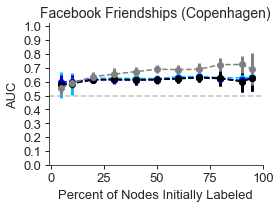

In [36]:
from matplotlib.backends.backend_pdf import PdfPages

alpha_empirical = 0.4

%matplotlib inline
nbins = 45
f, (ax1) = plt.subplots(1, 1, 
                    sharey=False, sharex=False,
                figsize=(4,3))

plt.setp(ax1, xticks=[0,25,50,75,100])


ax1.set_xticks([0,25,50,75,100])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0, labelsize = 13)

w = 1.5
width = 0.15
ax1.errorbar(percent_initially_labelled*100, mean_wt_auc_x1_lbfgs,
            yerr=se_wt_auc_x1, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='deepskyblue')

ax1.errorbar(percent_initially_labelled*100, mean_wt_auc_x2_lbfgs,
    yerr=se_wt_auc_x2, fmt='--o', capthick=2,
    alpha=1, elinewidth=3, color='blue')
ax1.errorbar(percent_initially_labelled*100, mean_wt_auc_x3_lbfgs,
    yerr=se_wt_auc_x3, fmt='--o', capthick=2,
    alpha=1, elinewidth=3, color='darkblue')
ax1.errorbar(percent_initially_labelled*100, mean_wt_auc_xall_lbfgs,
    yerr=se_wt_auc_xall, fmt='--o', capthick=2,
    alpha=1, elinewidth=3, color='black')
ax1.errorbar(percent_initially_labelled*100, mean_wt_LINK_RM,
    yerr=se_wt_LINK_RM, fmt='--o', capthick=2,
    alpha=1, elinewidth=3, color='gray')

#ax1.errorbar(percent_initially_labelled*100, df_results.mean_wt_node2vec,
#    yerr=df_results.se_wt_node2vec, fmt='--o', capthick=2,
#    alpha=1, elinewidth=3, color='red')





## UPDATE HERE
#ax.set_xticklabels(x_ticks, rotation=0, fontsize=8)
#ax.set_yticklabels(y_ticks, rotation=0, fontsize=8)


ax1.set_ylabel('AUC', size=13)
ax1.set_xlabel('Percent of Nodes Initially Labeled', size=13)


#ax1.set_xlim(-1,np.max(np.array(range(len(acc_generic)))*w)+1)
ax1.set_ylim(0,1.02)
plt.yticks(np.arange(0,1.02,0.1))
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_xlim(-1,100)
plt.axhline(0.5, color='gray', linestyle='--', alpha = 0.5)

plt.title('Facebook Friendships (Copenhagen)',fontsize=14)
plt.tight_layout()
#plt.show()

#figs-ICWSM-revision

In [37]:
df_results = pd.DataFrame({'mean_wt_auc_x1_lbfgs': mean_wt_auc_x1_lbfgs,
                            'se_wt_auc_x1': se_wt_auc_x1,
                            'mean_wt_auc_x2_lbfgs': mean_wt_auc_x2_lbfgs,
                            'se_wt_auc_x2': se_wt_auc_x2,
                            'mean_wt_auc_x3_lbfgs': mean_wt_auc_x3_lbfgs,
                            'se_wt_auc_x3': se_wt_auc_x3,
                            'mean_wt_auc_xall_lbfgs': mean_wt_auc_xall_lbfgs,
                            'se_wt_auc_xall': se_wt_auc_xall,
                           'mean_wt_LINK_RM':mean_wt_LINK_RM,
                           'se_wt_LINK_RM': se_wt_LINK_RM,
                           #'mean_wt_node2vec':mean_wt_node2vec_C_LRCV,
                           #'se_wt_node2vec':se_wt_node2vec_LRCV
                            })
df_results.to_csv('NEWCopenhagenResultsICWSMRevision.csv',sep=',', index = False)